<div style = "border: solid green 2px; padding:20px">

**Название проекта:**     
Анализ пользовательского поведения в мобильном приложении

**Цель исследования:**

Изучение воронки продаж и результатов A/A/B-эксперимента

**Ход исследования:**

1. Загрузка данных и подготовка их к анализу
2. Проверка данных
3. Воронка событий
4. Результаты эксперимента
5. Выводы

**Краткое описание проекта:**

Компания - стартап по продаже продуктов питания. 
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить какой шрифт лучше.

**Описание начальных данных:**

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# 1. Загрузка данных и подготовка их к анализу

## 1.1. Обзор данных

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from plotly import graph_objects as go
from statsmodels.stats.multitest import multipletests

In [ ]:
# загружаем данные
df = pd.read_csv('/content/drive/MyDrive/ЯПрактикум - АЛЛА/Спринт 10. Событийная аналитика. Сборный проект/logs_exp.csv', sep='\t')

In [ ]:
# чтобы распечатывались все выводы одной ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# откроем таблицу df и посмотрим общую информацию о ней
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## 1.2. Предобработка данных

In [ ]:
# переименуем столбцы
df = df.rename(columns={'EventName' : 'event_name', 'DeviceIDHash' : 'user_id', 'EventTimestamp' : 'timestamp', 'ExpId' : 'exp_id'})

In [ ]:
# проверим изменения
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,event_name,user_id,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
# проверим данные на наличие пропусков
df.isna().sum()

event_name    0
user_id       0
timestamp     0
exp_id        0
dtype: int64

In [ ]:
# проверим данные на наличие дубликатов
df.duplicated().sum()

413

In [ ]:
# удалим дубликаты
df = df.drop_duplicates() 

In [ ]:
# перепроверим данные на наличие дубликатов
df.duplicated().sum()

0

In [ ]:
# добавим столбец с датой и временем
df['date_time'] = pd.to_datetime(df['timestamp'], unit='s')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# добавим столбец с датой
df['date'] = df['date_time'].astype('datetime64[D]')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# выведем обновленную таблицу
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


,event_name,user_id,timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [ ]:
# проверим, нет ли в данных пользователей, участвовавших в нескольких группах теста сразу
# способ 1
pd.options.display.max_rows=8000
df.groupby('user_id').agg({'exp_id':'nunique'}).query('exp_id > 1')

,exp_id
user_id,


In [ ]:
# проверим, нет ли в данных пользователей, участвовавших в нескольких группах теста сразу
# способ 2
df.groupby('user_id')['exp_id'].nunique()[df.groupby('user_id')['exp_id'].nunique() > 1].index

Int64Index([], dtype='int64', name='user_id')

Итоговая таблица пуста, можно сделать вывод, что в исходной таблице также нет пользователей, участвующих в двух и более группах сразу.

**в данном разделе мы:**
- исправили наименования столбцов
- проверли данные на наличие пропусков
- проверили данные на наличие дубликатов и удалили их
- добавили столбцы с данными о дате/времени и преобразовали их
- проверили, нет ли в данных пользователей, участвовавших в нескольких группах теста сразу

# 2. Проверка данных

## 2.1. Определение количества событий и пользователей за весь период

In [ ]:
# вычислим сколько всего событий в логе
event_cnt = len(df)
'Всего событий в логе: {}'.format(event_cnt)

'Всего событий в логе: 243713'

In [ ]:
# вычислим сколько всего пользователей в логе
user_cnt = df['user_id'].nunique()
'Всего пользователей в логе: {}'.format(user_cnt)

'Всего пользователей в логе: 7551'

In [ ]:
# вычислим количество событий на одного пользователя:
'Среднее количество событий на одного пользователя: {}'.format(int(round(event_cnt/user_cnt, 0)))
'Медианное количество событий на одного пользователя: {}'.format(df['user_id'].value_counts().median())
'Минимальное количество событий на одного пользователя: {}'.format(df['user_id'].value_counts().min())
'Максимальное количество событий на одного пользователя: {}'.format(df['user_id'].value_counts().max())

'Среднее количество событий на одного пользователя: 32'

'Медианное количество событий на одного пользователя: 20.0'

'Минимальное количество событий на одного пользователя: 1'

'Максимальное количество событий на одного пользователя: 2307'

Подсчитав количество событий на одного пользователя разными способами можем сделать вывод о наличии выбросов и смещении распределения, так как среднее и медиана отличаются

## 2.2. Определение периода

In [ ]:
# найдем минимальную и максимальную даты периода
min_date = df['date_time'].min()
max_date = df['date_time'].max()
'Временные рамки: начало - {}, конец - {}'.format(min_date, max_date)

'Временные рамки: начало - 2019-07-25 04:43:36, конец - 2019-08-07 21:15:17'

## 2.3. Определение актуального периода

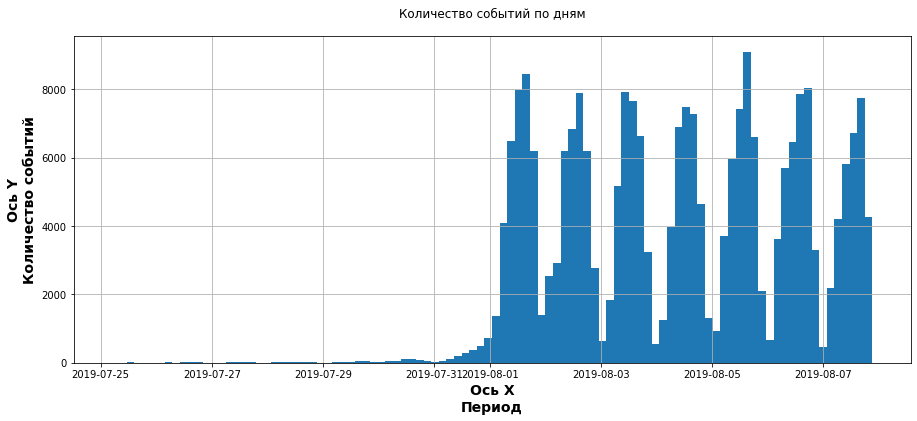

In [ ]:
# построим гистограмму по дате и времени
plt.figure(figsize=(15,6))
df['date_time'].hist(bins=100)

plt.title('Количество событий по дням', pad=20)
plt.xlabel("Ось X\nПериод", fontsize=14, fontweight="bold")
plt.ylabel("Ось Y\nКоличество событий", fontsize=14, fontweight="bold");

По полученной гистограмме видим, что у нас имеются неодинаковые данные за весь период.

In [ ]:
# отбросим старые данные и определим период времени, которым располагаем на самом деле - с 2019-08-01 по 2019-08-07
actual_period = df.query('date >= "2019-08-01"')

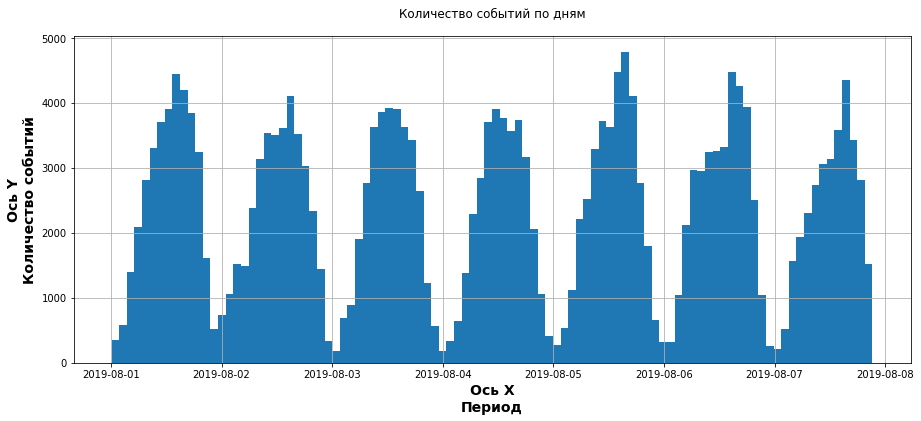

In [ ]:
# посмотрим повторно на гистограмму по дате и времени
plt.figure(figsize=(15,6))
actual_period['date_time'].hist(bins=100)

plt.title('Количество событий по дням', pad=20)
plt.xlabel("Ось X\nПериод", fontsize=14, fontweight="bold")
plt.ylabel("Ось Y\nКоличество событий", fontsize=14, fontweight="bold");

## 2.4. Определение количества событий и пользователей за актуальный период

In [ ]:
# вычислим сколько осталось событий за актуальный период
actual_event_cnt = actual_period['event_name'].value_counts().sum()
'Количество событий до актуального периода - {}, после - {}. Разность - {} или {}%'.format(
                                                                        event_cnt, actual_event_cnt,
                                                                        event_cnt - actual_event_cnt,
                                                                        round(100-actual_event_cnt/event_cnt*100, 2))

'Количество событий до актуального периода - 243713, после - 240887. Разность - 2826 или 1.16%'

In [ ]:
# вычислим сколько осталось пользователей за актуальный период
actual_user_cnt = actual_period['user_id'].nunique()
'Количество пользователей до актуального периода - {}, после - {}. Разность - {} или {}%'.format(
                                                                        user_cnt, actual_user_cnt,
                                                                        user_cnt - actual_user_cnt,
                                                                        round(100-actual_user_cnt/user_cnt*100, 2))

'Количество пользователей до актуального периода - 7551, после - 7534. Разность - 17 или 0.23%'

Таким образом после фильтрации мы потеряли 2826 событий и 17 пользователей.

## 2.5. Проверка наличия пользователей во всех экспериментальных группах за актуальный период

In [ ]:
# выведем пользователей по группам
user_pivot = actual_period.pivot_table(index='exp_id',values='user_id',aggfunc='nunique')
user_pivot['share'] = round(user_pivot['user_id']/user_pivot['user_id'].sum()*100)
user_pivot.sort_values('exp_id', ascending=False).head()

,user_id,share
exp_id,,
248,2537,34.0
247,2513,33.0
246,2484,33.0


Из каждой группы есть пользователи. Различие в количестве пользователей в группах на уровне 1% не критично, можно приступить к тесту.

# 3. Воронка событий

## 3.1. Какие события есть в логах и как часто они встречаются. 

In [ ]:
# выведем события
actual_period['event_name'].value_counts().to_frame()

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Самым частоповторяющимся событием является - MainScreenAppear (появление главного экрана), что логично.

Далее OffersScreenAppear - предложение о товаре (экран с товаром) и CartScreenAppear - переход в корзину (экран с корзиной), примерно с одинаковой частотой.

## 3.2. Сколько пользователей совершали каждое из этих событий. 

In [ ]:
# выведем пользователей по группам
# посчитаем долю пользователей, которые хоть раз совершали событие
user_event = (actual_period
                   .groupby('event_name')
                   .agg(number_of_users = ('user_id', 'nunique'))
                   .reset_index()
                   .sort_values('number_of_users', ascending=False)
                   .assign(user_share = lambda x: x['number_of_users'] / actual_period['user_id'].nunique())
                  )
user_event

,event_name,number_of_users,user_share
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


В отличии от предыдущего шага, видим не совсем ожидаемое значение доли пользователей для этапа MainScreenAppear. Как оказалось, не все пользователи видят главный экран. Возможно после загрузки приложения и ознакомления с руководством, небольшая часть пользователей все же решают не продолжать дальнейшее "знакомство" с приложением.

## 3.3. В каком порядке происходят события

Предположим, что события происходят в следующем порядке:

1. MainScreenAppear - появление главного экрана
2. Tutorial - руководство по использоваю приложения
3. OffersScreenAppear - предложение о товаре (экран с товаром)
4. CartScreenAppear - переход в корзину (экран с корзиной)
5. PaymentScreenSuccessful - оплата (экран успешной оплаты)


Этап Tutorial можно не учитывать при расчёте воронки, так как не обязателен и прямо не влияет на покупки пользователей. Так же видим, что событий этого типа слишком мало по сравнению с другими.

## 3.4. Воронка событий

In [ ]:
# построим воронку событий и посмотрим, сколько пользователей побывали на каждом из этапов
# удалим тип Tutorial
funnel = user_event[user_event['event_name'] != 'Tutorial']

fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['number_of_users'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous+percent total",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 3, 2, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(title="Воронка событий", width=900, height=500)

fig.show()

Пользователи, которые побывали на первом этапе возьмем за общее количество пользователей (100%).

Тогда, на втором этапе побывали только 62% пользователей. На данном этапе теряется больше всего пользователей.

Доля пользователей, которая доходит от первого события до оплаты составляет 48%.

# 4. Результаты эксперимента 

## 4.1. Количество пользователей по группам

In [ ]:
# посмотрим, какое количество пользователей относятся к каждой группе
actual_period.groupby('exp_id')['user_id'].nunique().to_frame()

,user_id
exp_id,
246,2484
247,2513
248,2537


In [ ]:
# выведем информацию по событиям по каждой группе
users_by_events = actual_period.pivot_table(index = 'exp_id',
                                   columns = 'event_name',
                                   values = 'user_id',
                                   aggfunc = 'nunique').reset_index()
users_by_events

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


In [ ]:
# добавим таблице users_by_events столбец с количеством пользователей в каждой из групп:
users_total = actual_period.groupby('exp_id')['user_id'].nunique()
users_by_events['users_total'] = users_by_events['exp_id'].apply(lambda x: users_total.loc[x])
users_by_events = users_by_events.set_index('exp_id')
users_by_events

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,users_total
exp_id,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


In [ ]:
# добавим информацию по группе 246_247, которая будет объединять две А-группы ААВ-теста:
new_row = users_by_events.loc[246] + users_by_events.loc[247]
new_row.name = '246_247'
users_by_events = users_by_events.append([new_row])
users_by_events = users_by_events[['MainScreenAppear', 'OffersScreenAppear',
                                   'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial', 'users_total']]
users_by_events = users_by_events.reindex([246, 247, '246_247', 248])
users_by_events

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial,users_total
246,2450,1542,1266,1200,278,2484
247,2476,1520,1238,1158,283,2513
246_247,4926,3062,2504,2358,561,4997
248,2493,1531,1230,1181,279,2537


Мы видим, что самым популярным событием становится показ главного экрана приложения (MainScreenAppear)

## 4.2. Проверка гипотез о различии в долях между выборками

**Сформулируем гипотезы**
- Нулевая: различий в долях между группами нет.
- Альтернативная: различия в долях между группами есть.

Проверять гипотезу о равенстве долей будем при помощи Z-критерия.

В шаге №7 мы выявили, что различие в количестве пользователей в группах на уровне 1%, что является не критичным, можно приступить к тесту

In [ ]:
# напишем функцию для проверки
def st_test(part0, part1, total0, total1, alpha):  
    p1 = part0 / total0 
    p2 = part1 / total1 
    p_combined = (part0 + part1) / (total0 + total1) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [ ]:
# сравним доли пользователей между выборками 246 и 247 по самому популярному событию, а также по всем остальным
# А-группа 246: group_1
# А-группа 247: group_2
pd.options.display.max_colwidth = 150
AA_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]
group_1 = 246
current_row = users_by_events.loc[group_1]
group_2 = 247
for event_number in range(4):
    curr_event = users_by_events.columns[event_number]
    p_value_result = st_test(current_row[curr_event], 
                                   users_by_events[curr_event][group_2],
                                   current_row['users_total'],
                                   users_by_events['users_total'][group_2],
                                   alpha = 0.05
                           )
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': users_by_events.columns[event_number],
               'p_alpha': 0.05,
               'p_value': round(p_value_result, 5),
               'Результат': result_options[int(p_value_result >= 0.05)]}
    AA_pivot = AA_pivot.append([new_row])

AA_pivot.index = range(len(AA_pivot))
AA_pivot

,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,247,MainScreenAppear,0.05,0.75706,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,246,247,OffersScreenAppear,0.05,0.24810,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
2,246,247,CartScreenAppear,0.05,0.22883,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,246,247,PaymentScreenSuccessful,0.05,0.11457,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"


Тест проведен корректно - статзначимых различий между двумя А-группами не обнаружено.

Теперь посмотрим на результаты АВ-теста:

In [ ]:
# А-группа: 246, В-группа: 248
# А-группа: 247, В-группа: 248;
# А-группа: объединение 246 и 247 групп

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = users_by_events.index[i]
    current_row = users_by_events.loc[group_1]
    group_2 = 248
    for event_number in range(4):
        curr_event = users_by_events.columns[event_number]
        p_value_result = st_test(current_row[curr_event], 
                                       users_by_events[curr_event][group_2],
                                       current_row['users_total'],
                                       users_by_events['users_total'][group_2],
                                       alpha = 0.05
                               )
        new_row = {'Группа_1': group_1,
                   'Группа_2': group_2,
                   'Событие': users_by_events.columns[event_number],
                   'p_alpha': 0.05,
                   'p_value': round(p_value_result, 5),
                   'Результат': result_options[int(p_value_result >= 0.05)]}
        AB_pivot = AB_pivot.append([new_row])

AB_pivot.index = range(len(AB_pivot))
AB_pivot

,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,248,MainScreenAppear,0.05,0.29497,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,246,248,OffersScreenAppear,0.05,0.20836,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
2,246,248,CartScreenAppear,0.05,0.07843,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,246,248,PaymentScreenSuccessful,0.05,0.21226,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
4,247,248,MainScreenAppear,0.05,0.45871,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
5,247,248,OffersScreenAppear,0.05,0.91978,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
6,247,248,CartScreenAppear,0.05,0.57862,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
7,247,248,PaymentScreenSuccessful,0.05,0.73734,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
8,246_247,248,MainScreenAppear,0.05,0.29425,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
9,246_247,248,OffersScreenAppear,0.05,0.43426,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"


Статзначимых отличий не обнаружено.

Мы проводим множественный тест (берем несколько выборок из одного и того же набора данных). Особенность данного теста в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Поэтому скорректируем наши конечные p_value для сравнения их значений с alpha, для этого выберем метод Шидака.

In [ ]:
# пересчитаем данные по таблице (столбец p_value) и обновим выводы, если это потребуется (столбец Результат)
result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"]

pvalues_corr_list = []  # откорректированные p-value
final_results = []  # итоговые результаты (отклоняем или нет)

for i in range(0, len(AB_pivot), 4):
    pvalues_list = AB_pivot.loc[i:i+3, 'p_value'].tolist()
    results, p_value_corr, _, _ = multipletests(pvalues_list, method='holm-sidak')
    pvalues_corr_list.extend([round(x, 5) for x in p_value_corr])
    final_results.extend([result_options[0] if x else result_options[1] for x in results])

AB_pivot = AB_pivot.drop('Результат', axis=1)
AB_pivot['p_value_corr'] = pvalues_corr_list
AB_pivot['Итоговый результат'] = final_results

AB_pivot

,Группа_1,Группа_2,Событие,p_alpha,p_value,p_value_corr,Итоговый результат
0,246,248,MainScreenAppear,0.05,0.29497,0.50388,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
1,246,248,OffersScreenAppear,0.05,0.20836,0.50388,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
2,246,248,CartScreenAppear,0.05,0.07843,0.27870,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
3,246,248,PaymentScreenSuccessful,0.05,0.21226,0.50388,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
4,247,248,MainScreenAppear,0.05,0.45871,0.91415,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
5,247,248,OffersScreenAppear,0.05,0.91978,0.93101,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
6,247,248,CartScreenAppear,0.05,0.57862,0.92518,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
7,247,248,PaymentScreenSuccessful,0.05,0.73734,0.93101,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
8,246_247,248,MainScreenAppear,0.05,0.29425,0.64848,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
9,246_247,248,OffersScreenAppear,0.05,0.43426,0.67994,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"


Результаты не изменились, внесённые изменения никак не повлияли на метрики и на поведения пользователей.

# 5. Выводы

- события складываются в воронку продаж
1. MainScreenAppear - появление главного экрана
2. Tutorial - руководство по использоваю приложения
3. OffersScreenAppear - предложение о товаре (экран с товаром)
4. CartScreenAppear - переход в корзину (экран с корзиной)
5. PaymentScreenSuccessful - оплата (экран успешной оплаты)

- самое популярное событие - показ главного экрана, а самое непопулярное - показ экрана оплаты. 

- судя по количеству событий, предположительно Tutorial является дополнительным (необязатальным).

- было подсчитано, какой процент пользователей проходит на каждый из этапов воронки. На экран с предложением проходит всего 62% пользователей, а от показа главного экрана до итоговой оплаты доходит всего 48 % пользователей.

- статистически значимых различий между двумя А группами не найдено, пользователи распределены по группам корректно

- статистически значимых различий между А и В группами также не обнаружено, гипотеза о том, что изменение шрифта как-то повлияет на продажи, не подтвердилась. Можно сделать вывод, что текст на сайте менять не нужно.

- НО! до 01.08.201 совершается очень мало событий, после удаления ранних данных было потеряно 2826 событий (1,16% от общего числа), возможно стоит собрать данные дополнительно ещё за 1 неделю и провести повторный эксперимент. Но ожидать того, что ситуация кардинально изменится и мы обнаружим статистически значимые различия между группами, не стоит, учитывая полученные величины p_value.

**Описание шагов исследования**
1. Загрузка данных и подготовка их к анализу
- Обзор данных
- Предобработка данных

2. Проверка данных
- Определение количества событий и пользователей за весь период
- Определение периода
- Определение актуального периода
- Определение количества событий и пользователей за актуальный период
- Проверка наличия пользователей во всех экспериментальных группах за актуальный период

3. Воронка событий
- Посмотрим, какие события есть в логах и как часто они встречаются
- Сколько пользователей совершали каждое из этих событий
- В каком порядке происходят события
- Воронка событий

4. Результаты эксперимента 
- Количество пользователей по группам
- Проверка гипотез о различии в долях между выборками

5. Выводы